# KAN (Kolmogorov-Arnold Networks) - CSK Modulation Analysis

**Refactored Version** - Improved Organization, No Normalization, Enhanced Visualizations

## Overview
This notebook analyzes KAN network performance for 4-CSK and 8-CSK modulation classification.

### Key Improvements:
- Clear section organization
- **No data normalization** (raw features used)
- Comprehensive hyperparameter search
- Enhanced visualizations with result tables
- Top configuration analysis
- KAN vs FNN comparison

### Datasets:
- `data_4csk.csv` - 4-CSK modulation
- `data_8csk.csv` - 8-CSK modulation

---
# Section 1: Setup and Configuration

## 1.1 Imports

In [1]:
import os
import copy
import itertools
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

try:
    from torch_relu_kan import ReLUKAN
    print('ReLUKAN imported successfully')
except ImportError:
    print('Error: torch_relu_kan.py not found')
    raise

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# print(f'Random seed: {SEED}')

ReLUKAN imported successfully
Using device: cuda


## 1.2 Configuration

In [2]:
# Output directory
OUTPUT_DIR = 'results_refactored'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Results directory: {OUTPUT_DIR}')

# Training configuration
CONFIG = {
    'search_epochs': 1000,
    'final_epochs': 1000,
    'n_repeats': 10,  # Updated to 10 independent runs
}

# FNN configurations per dataset
FNN_CONFIGS = {
    'data_4csk.csv': [10],      # FNN-1: 1 hidden layer, 10 neurons
    'data_8csk.csv': [100],     # FNN-3: 1 hidden layer, 100 neurons
}

print('\nConfiguration:')
for k, v in CONFIG.items():
    print(f'  {k}: {v}')
print('\nFNN Configurations:')
for dataset, layers in FNN_CONFIGS.items():
    print(f'  {dataset}: {layers}')

Results directory: results_refactored

Configuration:
  search_epochs: 1000
  final_epochs: 1000
  n_repeats: 10

FNN Configurations:
  data_4csk.csv: [10]
  data_8csk.csv: [100]


## 1.3 Feature Sets

In [3]:
FEATURE_SETS = {
    r'$T_{wCE}$': ['Vr', 'Vg', 'Vb'],
    r'$T$': ['R', 'G', 'B'],
    r"$C'$": ['X', 'Y', 'Z'],
    r"$c'$": ['x', 'y'],
    r"$C'_{wCE}$": ['X_ne', 'Y_ne', 'Z_ne'],
    r"$c'_{wCE}$": ['x_ne', 'y_ne']
}

print('Feature Sets:')
for name, cols in FEATURE_SETS.items():
    print(f'  {name}: {cols}')

Feature Sets:
  $T_{wCE}$: ['Vr', 'Vg', 'Vb']
  $T$: ['R', 'G', 'B']
  $C'$: ['X', 'Y', 'Z']
  $c'$: ['x', 'y']
  $C'_{wCE}$: ['X_ne', 'Y_ne', 'Z_ne']
  $c'_{wCE}$: ['x_ne', 'y_ne']


## 1.4 Hyperparameter Grid

In [4]:
PARAM_GRID = {
    'grid': [3],
    'k': [4],
    'lr': [1e-3],
    'hidden_layers': [[10], [25], [100], [10,10], [10,10,10]]
}

keys, values = zip(*PARAM_GRID.items())
PARAM_COMBINATIONS = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f'Total configurations: {len(PARAM_COMBINATIONS)}')

Total configurations: 5


## 1.5 Plotting Style

In [5]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
})
print('Plotting style configured')

Plotting style configured


---
# Section 2: Utility Functions

## 2.1 Data Loading - NO NORMALIZATION

In [26]:
def load_data(filepath, feature_cols, target_col='Symbol', 
              train_size=64, test_size=None, random_state=None):
    """
    Load and split data - NO NORMALIZATION.
    
    Args:
        filepath: Path to CSV file
        feature_cols: List of feature column names
        target_col: Target column name
        train_size: Number of training samples
        test_size: Number of test samples (None = use remaining)
        random_state: Random state for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test, num_classes
    """
    df = pd.read_csv(filepath)
    X = df[feature_cols].values
    y = df[target_col].values
    
    if test_size is not None:
        X_train, X_rest, y_train, y_rest = train_test_split(
            X, y, train_size=train_size, random_state=random_state, stratify=y)
        if len(X_rest) >= test_size:
            X_test, _, y_test, _ = train_test_split(
                X_rest, y_rest, train_size=test_size, random_state=random_state, stratify=y_rest)
        else:
            X_test, y_test = X_rest, y_rest
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_size, random_state=random_state, stratify=y)
    
    # Convert to tensors - NO NORMALIZATION
    X_train = torch.FloatTensor(X_train).unsqueeze(-1).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
    y_test = torch.LongTensor(y_test).to(device)
    
    return X_train, X_test, y_train, y_test, len(np.unique(y))

## 2.2 Training Function

In [7]:
def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=200, lr=1e-4, verbose=False, optimizer_type='adam'):
    """
    Train model and return best SER.
    
    Args:
        optimizer_type: 'adam' for KAN, 'lbfgs' for FNN
    """
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_type.lower() == 'lbfgs':
        optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=20, 
                                history_size=10, line_search_fn='strong_wolfe')
    else:  # adam
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'test_ser': [], 'test_acc': []}
    best_ser = 1.0
    best_model_state = None
    
    iterator = tqdm(range(epochs), desc='Training') if verbose else range(epochs)
    
    for epoch in iterator:
        model.train()
        
        if optimizer_type.lower() == 'lbfgs':
            # LBFGS requires closure function
            def closure():
                optimizer.zero_grad()
                output = model(X_train).squeeze(-1)
                loss = criterion(output, y_train)
                loss.backward()
                return loss
            
            optimizer.step(closure)
            # Get loss for history
            with torch.no_grad():
                output = model(X_train).squeeze(-1)
                loss = criterion(output, y_train)
        else:
            # Adam optimizer
            optimizer.zero_grad()
            output = model(X_train).squeeze(-1)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_out = model(X_test).squeeze(-1)
            _, preds = torch.max(test_out, 1)
            accuracy = (preds == y_test).float().mean().item()
            ser = 1.0 - accuracy
            
            history['test_ser'].append(ser)
            history['test_acc'].append(accuracy)
            
            if ser < best_ser:
                best_ser = ser
                best_model_state = copy.deepcopy(model.state_dict())
        
        if verbose and (epoch % 50 == 0):
            iterator.set_postfix(loss=loss.item(), ser=ser)
    
    return best_ser, history, best_model_state

## 2.3 Plotting Functions

In [8]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', filename=None):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Symbol')
    plt.ylabel('True Symbol')
    plt.grid(False)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(OUTPUT_DIR, filename + '.png'), dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_DIR, filename + '.pdf'), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_results_table(df, title='Results'):
    """Display results as a formatted table."""
    print(f'\n{title}')
    print('='*80)
    print(df.to_string(index=False))
    print('='*80)

In [9]:
def mle_predict(X_test_xy, reference_symbols):
    """
    MLE predictor using Euclidean distance.
    
    Args:
        X_test_xy: Test data (N, 2) with x, y coordinates
        reference_symbols: Reference symbol positions (num_classes, 2)
    
    Returns:
        predictions: Predicted class labels
    """
    # Compute Euclidean distance to each reference symbol
    distances = torch.cdist(X_test_xy, reference_symbols)  # (N, num_classes)
    predictions = torch.argmin(distances, dim=1)
    return predictions

print('MLE predictor function defined')

MLE predictor function defined


---
# Section 3: Model Definitions

## 3.1 FNN Baseline Model

In [10]:
class FNN(nn.Module):
    """Feedforward Neural Network baseline with softmax output."""
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Softmax(dim=1))  # Add softmax activation
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        if x.dim() == 3:
            x = x.squeeze(-1)
        return self.network(x).unsqueeze(-1)

print('FNN model defined with softmax output')

FNN model defined with softmax output


---
# Section 4: Experiments

Comprehensive analysis of KAN performance across different configurations.

## 4.1 Feature Selection and Hyperparameter Search

Systematic search across all feature sets and hyperparameter combinations.

In [11]:
# Storage for results
results = {
    'Dataset': [], 'Feature_Set': [], 'Hidden_Layers': [],
    'Mean_SER': [], 'Std_SER': [], 'Best_SER': []
}

best_configs = {}  # Store best configuration for each dataset

print('Starting Feature Selection and Hyperparameter Search...')
print('='*80)

# Use local seed for reproducibility
base_seed = 42

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f'\nDataset: {filename}')
    best_mean_ser = 1.0
    best_config = None
    
    for feat_name, cols in FEATURE_SETS.items():
        for params in PARAM_COMBINATIONS:
            sers = []
            
            # Multiple runs for statistics - EACH WITH DIFFERENT DATA SPLIT
            for run_idx in range(CONFIG['n_repeats']):
                # Use different random_state for each run
                random_state = base_seed + run_idx
                
                # Load data with different random state
                X_train, X_test, y_train, y_test, num_classes = load_data(
                    filename, cols, train_size=64, test_size=64,
                    random_state=random_state
                )
                
                # Define layers after we know num_classes
                if run_idx == 0:
                    layers = [len(cols)] + params['hidden_layers'] + [num_classes]
                
                model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
                best_ser, _, _ = train_model(
                    model, X_train, y_train, X_test, y_test,
                    epochs=CONFIG['search_epochs'],
                    lr=params['lr'],
                    optimizer_type='adam'
                )
                sers.append(best_ser)
            
            mean_ser = np.mean(sers)
            std_ser = np.std(sers)
            min_ser = np.min(sers)
            
            results['Dataset'].append(filename.replace('.csv', '').replace('data_', '').upper())
            results['Feature_Set'].append(feat_name)
            results['Hidden_Layers'].append(str(params['hidden_layers']))
            results['Mean_SER'].append(mean_ser)
            results['Std_SER'].append(std_ser)
            results['Best_SER'].append(min_ser)
            
            if mean_ser < best_mean_ser:
                best_mean_ser = mean_ser
                best_config = {
                    'features': feat_name,
                    'columns': cols,
                    'params': params,
                    'mean_ser': mean_ser,
                    'std_ser': std_ser
                }
    
    best_configs[filename] = best_config
    print(f'  Best: {best_config["features"]} | SER: {best_config["mean_ser"]:.4f} +/- {best_config["std_ser"]:.4f}')

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_DIR, 'feature_search_results.csv'), index=False)
print(f'\nResults saved to {OUTPUT_DIR}/feature_search_results.csv')

Starting Feature Selection and Hyperparameter Search...

Dataset: data_4csk.csv
  Best: $T_{wCE}$ | SER: 0.1078 +/- 0.0226

Dataset: data_8csk.csv
  Best: $T_{wCE}$ | SER: 0.0906 +/- 0.0195

Results saved to results_refactored/feature_search_results.csv


### 4.1.1 Results Table - Best Configuration per Feature Set

In [12]:
# Get best configuration for each feature set
best_per_feature = df_results.loc[
    df_results.groupby(['Dataset', 'Feature_Set'])['Mean_SER'].idxmin()
].copy()

# Display table
display_df = best_per_feature[['Dataset', 'Feature_Set', 'Hidden_Layers', 'Mean_SER', 'Std_SER']].copy()
display_df['Mean_SER'] = display_df['Mean_SER'].apply(lambda x: f'{x:.4f}')
display_df['Std_SER'] = display_df['Std_SER'].apply(lambda x: f'{x:.4f}')

plot_results_table(display_df, 'Best Configuration per Feature Set')


Best Configuration per Feature Set
Dataset Feature_Set Hidden_Layers Mean_SER Std_SER
   4CSK        $C'$         [100]   0.3297  0.0398
   4CSK  $C'_{wCE}$          [25]   0.1219  0.0418
   4CSK         $T$         [100]   0.2188  0.0328
   4CSK   $T_{wCE}$         [100]   0.1078  0.0226
   4CSK        $c'$         [100]   0.1875  0.0537
   4CSK  $c'_{wCE}$         [100]   0.1688  0.0513
   8CSK        $C'$          [25]   0.5281  0.0643
   8CSK  $C'_{wCE}$      [10, 10]   0.1062  0.0412
   8CSK         $T$         [100]   0.4562  0.0584
   8CSK   $T_{wCE}$          [25]   0.0906  0.0195
   8CSK        $c'$          [10]   0.1141  0.0357
   8CSK  $c'_{wCE}$          [10]   0.1094  0.0413


### 4.1.2 Visualization - Feature Set Comparison

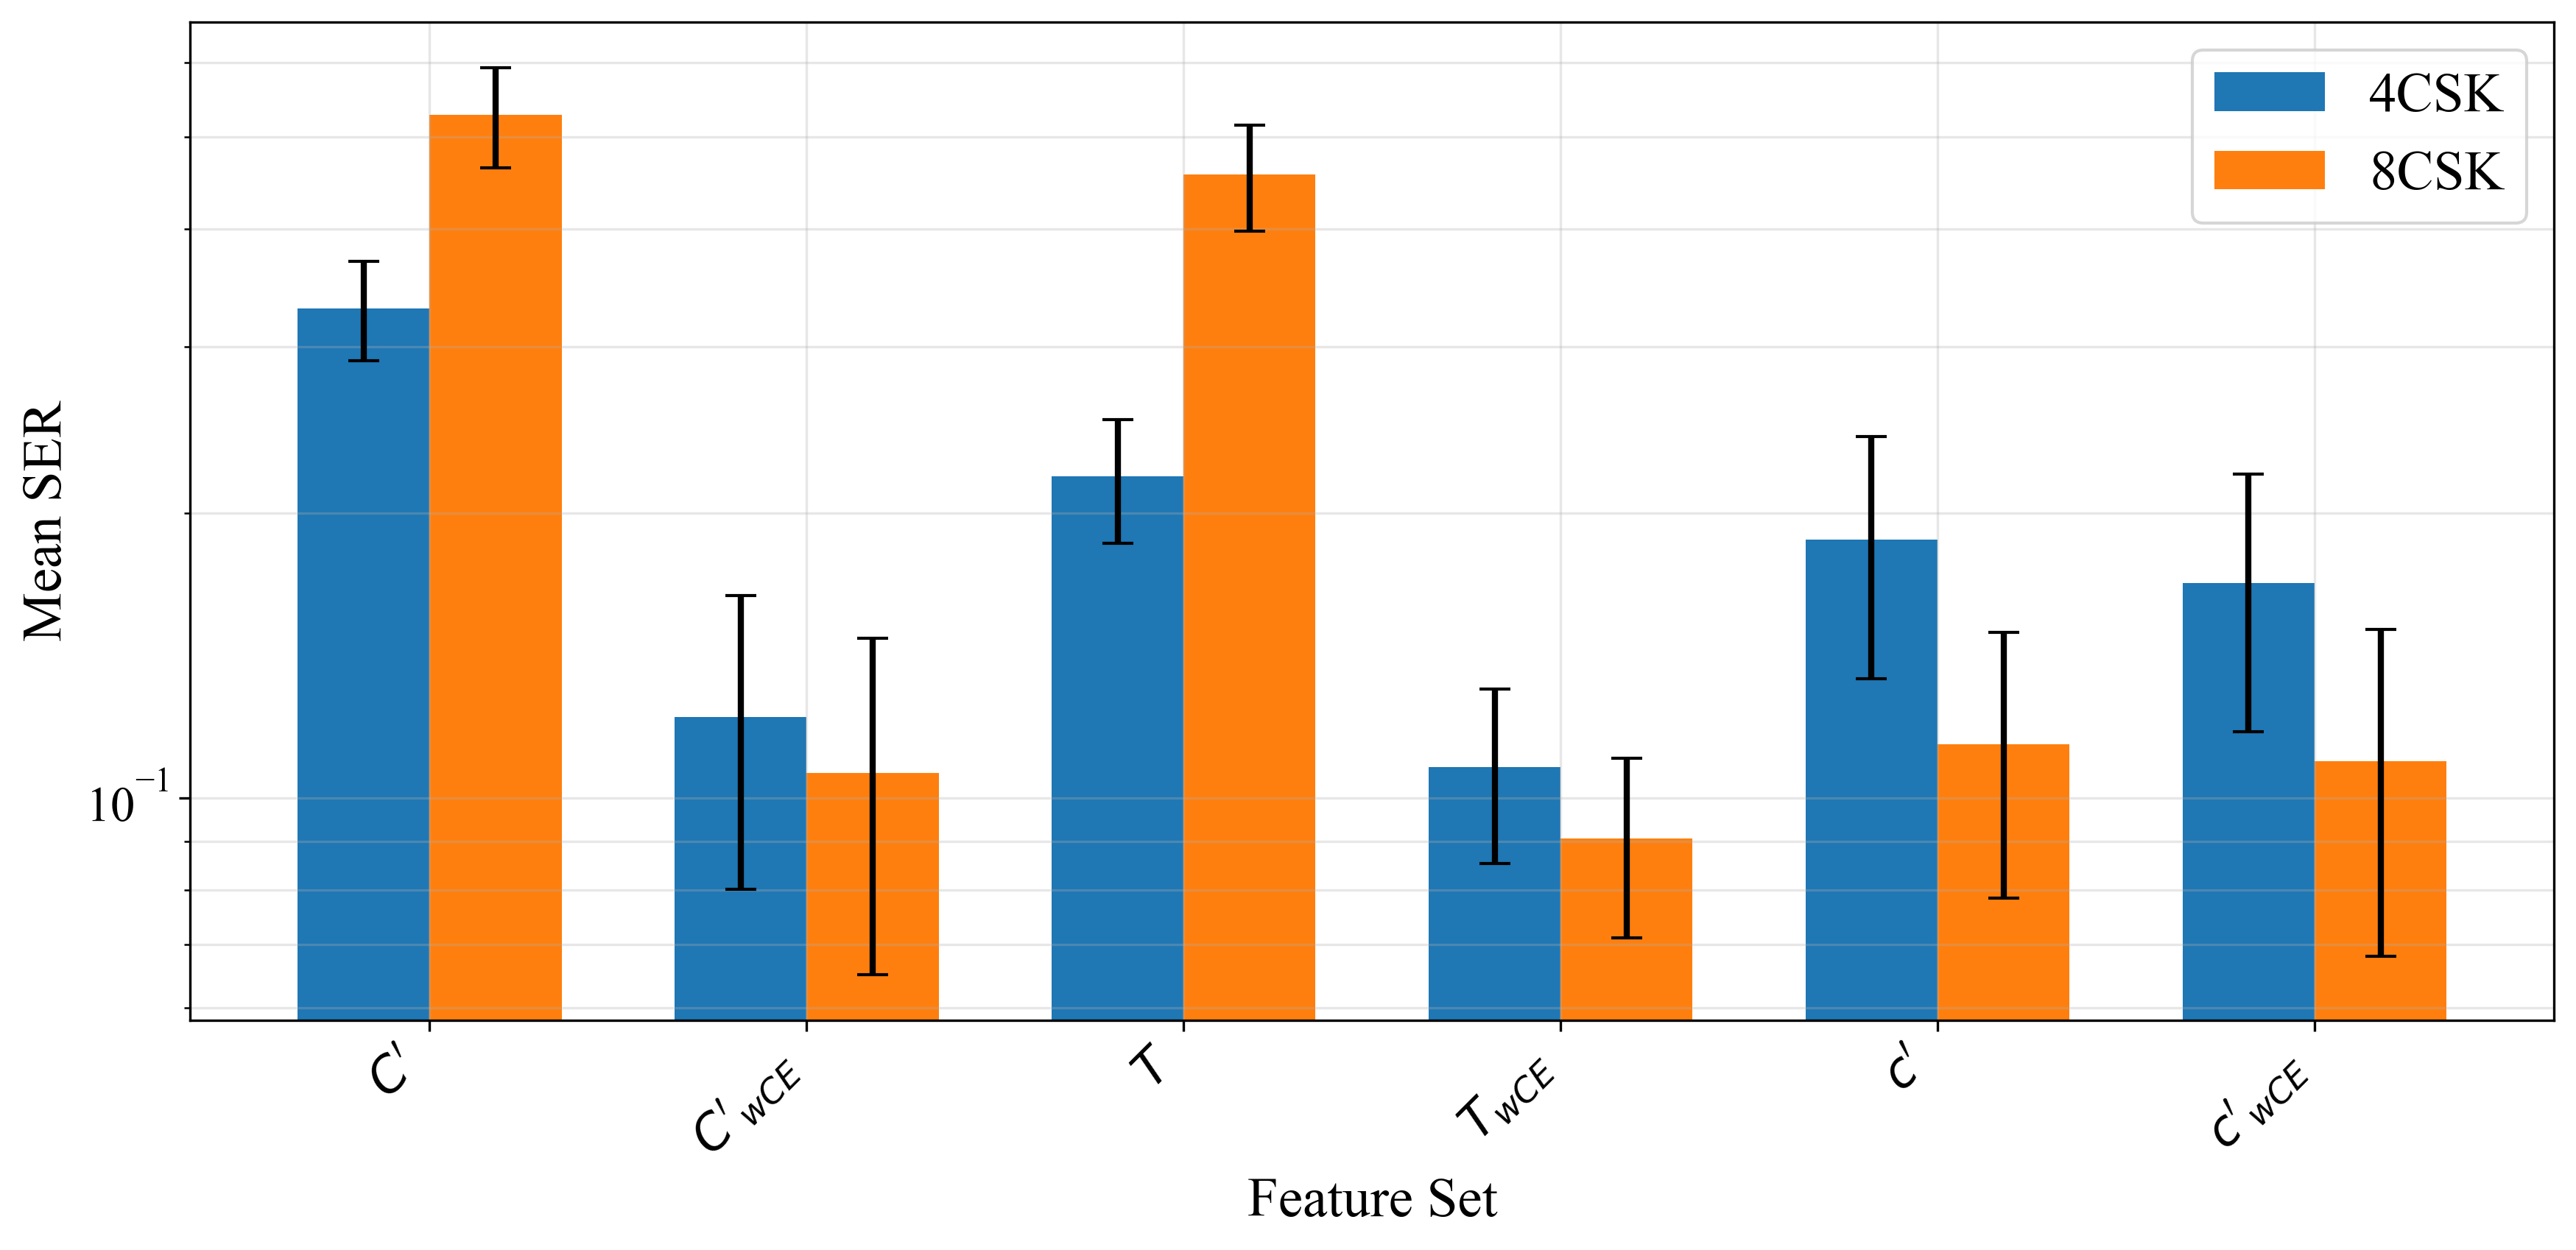

In [13]:
# Bar plot comparing feature sets
datasets = best_per_feature['Dataset'].unique()
features = best_per_feature['Feature_Set'].unique()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(features))
width = 0.35

for i, ds in enumerate(datasets):
    subset = best_per_feature[best_per_feature['Dataset'] == ds]
    subset = subset.set_index('Feature_Set').reindex(features).reset_index()
    
    ax.bar(x + i*width, subset['Mean_SER'], width, 
           label=ds, yerr=subset['Std_SER'], capsize=5)

ax.set_ylabel('Mean SER')
ax.set_xlabel('Feature Set')
ax.set_xticks(x + width/2 if len(datasets) > 1 else x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()
ax.set_yscale('log')
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_comparison.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.show()

### 4.1.3 Top 5 Configurations per Dataset

In [14]:
for dataset in df_results['Dataset'].unique():
    print(f'Top 5 Configurations for {dataset}:')
    print('='*80)
    
    top5 = df_results[df_results['Dataset'] == dataset].nsmallest(5, 'Mean_SER')
    display_top5 = top5[['Feature_Set', 'Hidden_Layers', 'Mean_SER', 'Std_SER', 'Best_SER']].copy()
    display_top5['Mean_SER'] = display_top5['Mean_SER'].apply(lambda x: f'{x:.4f}')
    display_top5['Std_SER'] = display_top5['Std_SER'].apply(lambda x: f'{x:.4f}')
    display_top5['Best_SER'] = display_top5['Best_SER'].apply(lambda x: f'{x:.4f}')
    
    print(display_top5.to_string(index=False))
    print('='*80)

Top 5 Configurations for 4CSK:
Feature_Set Hidden_Layers Mean_SER Std_SER Best_SER
  $T_{wCE}$         [100]   0.1078  0.0226   0.0781
  $T_{wCE}$          [25]   0.1141  0.0377   0.0781
 $C'_{wCE}$          [25]   0.1219  0.0418   0.0781
  $T_{wCE}$      [10, 10]   0.1234  0.0422   0.0781
 $C'_{wCE}$         [100]   0.1234  0.0392   0.0781
Top 5 Configurations for 8CSK:
Feature_Set Hidden_Layers Mean_SER Std_SER Best_SER
  $T_{wCE}$          [25]   0.0906  0.0195   0.0625
  $T_{wCE}$          [10]   0.0922  0.0256   0.0625
  $T_{wCE}$         [100]   0.0922  0.0275   0.0625
  $T_{wCE}$      [10, 10]   0.1016  0.0245   0.0625
  $T_{wCE}$  [10, 10, 10]   0.1031  0.0420   0.0312


## 4.2 Sample Efficiency: KAN vs FNN

Compare KAN and FNN performance across different training set sizes.

In [ ]:
# Sample efficiency experiment
import pandas as pd
import torch
import numpy as np
import os

# Define training sizes
train_sizes = [8] + list(range(16, 1025, 16))
# train_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
test_size = 1024

efficiency_results = {
    'Dataset': [], 'Train_Size': [], 'Model': [], 'Mean_SER': [], 'Std_SER': []
}

# Use local seed base
base_seed = 42

print('Sample Efficiency Experiment')
print('='*80)

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f'\nDataset: {filename}')
    
    # Use best KAN configuration from previous experiment
    best_cfg = best_configs[filename]
    kan_cols = best_cfg['columns']
    params = best_cfg['params']
    
    # Set FNN-specific features
    if filename == 'data_4csk.csv':
        fnn_cols = ['Vr', 'Vg', 'Vb']  # FNN-1: voltage features
        fnn_hidden_layers = FNN_CONFIGS[filename]
    else:  # data_8csk.csv
        fnn_cols = ['X_ne', 'Y_ne', 'Z_ne']  # FNN-3: X_ne, Y_ne, Z_ne
        fnn_hidden_layers = FNN_CONFIGS[filename]
    
    for train_size in train_sizes:
        print(f'  Train size: {train_size}')
        
        # KAN - Independent runs with different data splits
        kan_sers = []
        for run_idx in range(CONFIG['n_repeats']):
            # 1. Generate unique seed
            current_seed = base_seed + run_idx
            
            # 2. Set global seeds
            np.random.seed(current_seed)
            torch.manual_seed(current_seed)
            
            # 3. Load data with unique random_state
            X_train, X_test, y_train, y_test, num_classes = load_data(
                filename, kan_cols, train_size=train_size, test_size=test_size,
                random_state=current_seed
            )
            
            # Define layers
            layers = [len(kan_cols)] + params['hidden_layers'] + [num_classes]
            
            model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
            best_ser, _, _ = train_model(
                model, X_train, y_train, X_test, y_test,
                epochs=CONFIG['final_epochs'],
                lr=params['lr'],
                optimizer_type='adam'
            )
            kan_sers.append(best_ser)
        
        # # FNN - Independent runs (Commented out but updated)
        # fnn_sers = []
        # for run_idx in range(CONFIG['n_repeats']):
        #     current_seed = base_seed + run_idx
        #     np.random.seed(current_seed)
        #     torch.manual_seed(current_seed)
        #
        #     X_train, X_test, y_train, y_test, num_classes = load_data(
        #         filename, fnn_cols, train_size=train_size, test_size=test_size,
        #         random_state=current_seed
        #     )
        #
        #     model = FNN(len(fnn_cols), fnn_hidden_layers, num_classes).to(device)
        #     best_ser, _, _ = train_model(
        #         model, X_train, y_train, X_test, y_test,
        #         epochs=CONFIG['final_epochs'],
        #         lr=1e-2,
        #         optimizer_type='adam'
        #     )
        #     fnn_sers.append(best_ser)
        
        ds_name = filename.replace('.csv', '').replace('data_', '').upper()
        
        # Save KAN results
        efficiency_results['Dataset'].extend([ds_name])
        efficiency_results['Train_Size'].extend([train_size])
        efficiency_results['Model'].extend(['KAN'])
        efficiency_results['Mean_SER'].extend([np.mean(kan_sers)])
        efficiency_results['Std_SER'].extend([np.std(kan_sers)])

        # # Save FNN results (Commented out)
        # efficiency_results['Dataset'].extend([ds_name])
        # efficiency_results['Train_Size'].extend([train_size])
        # efficiency_results['Model'].extend(['FNN'])
        # efficiency_results['Mean_SER'].extend([np.mean(fnn_sers)])
        # efficiency_results['Std_SER'].extend([np.std(fnn_sers)])

# Reset global seed (optional)
np.random.seed(base_seed)
torch.manual_seed(base_seed)

df_efficiency = pd.DataFrame(efficiency_results)
df_efficiency.to_csv(os.path.join(OUTPUT_DIR, 'sample_efficiency_results.csv'), index=False)
print(f'\nResults saved to {OUTPUT_DIR}/sample_efficiency_results.csv')

Sample Efficiency Experiment

Dataset: data_4csk.csv
  Train size: 8
  Train size: 16
  Train size: 32
  Train size: 48
  Train size: 64
  Train size: 80
  Train size: 96
  Train size: 112
  Train size: 128
  Train size: 144
  Train size: 160
  Train size: 176
  Train size: 192
  Train size: 208
  Train size: 224
  Train size: 240
  Train size: 256
  Train size: 272
  Train size: 288
  Train size: 304
  Train size: 320
  Train size: 336
  Train size: 352
  Train size: 368
  Train size: 384
  Train size: 400
  Train size: 416
  Train size: 432
  Train size: 448
  Train size: 464
  Train size: 480
  Train size: 496
  Train size: 512
  Train size: 528
  Train size: 544
  Train size: 560
  Train size: 576
  Train size: 592
  Train size: 608
  Train size: 624
  Train size: 640
  Train size: 656
  Train size: 672
  Train size: 688
  Train size: 704
  Train size: 720
  Train size: 736
  Train size: 752
  Train size: 768
  Train size: 784
  Train size: 800
  Train size: 816
  Train size: 832
 

### 4.2.1 Sample Efficiency Plots

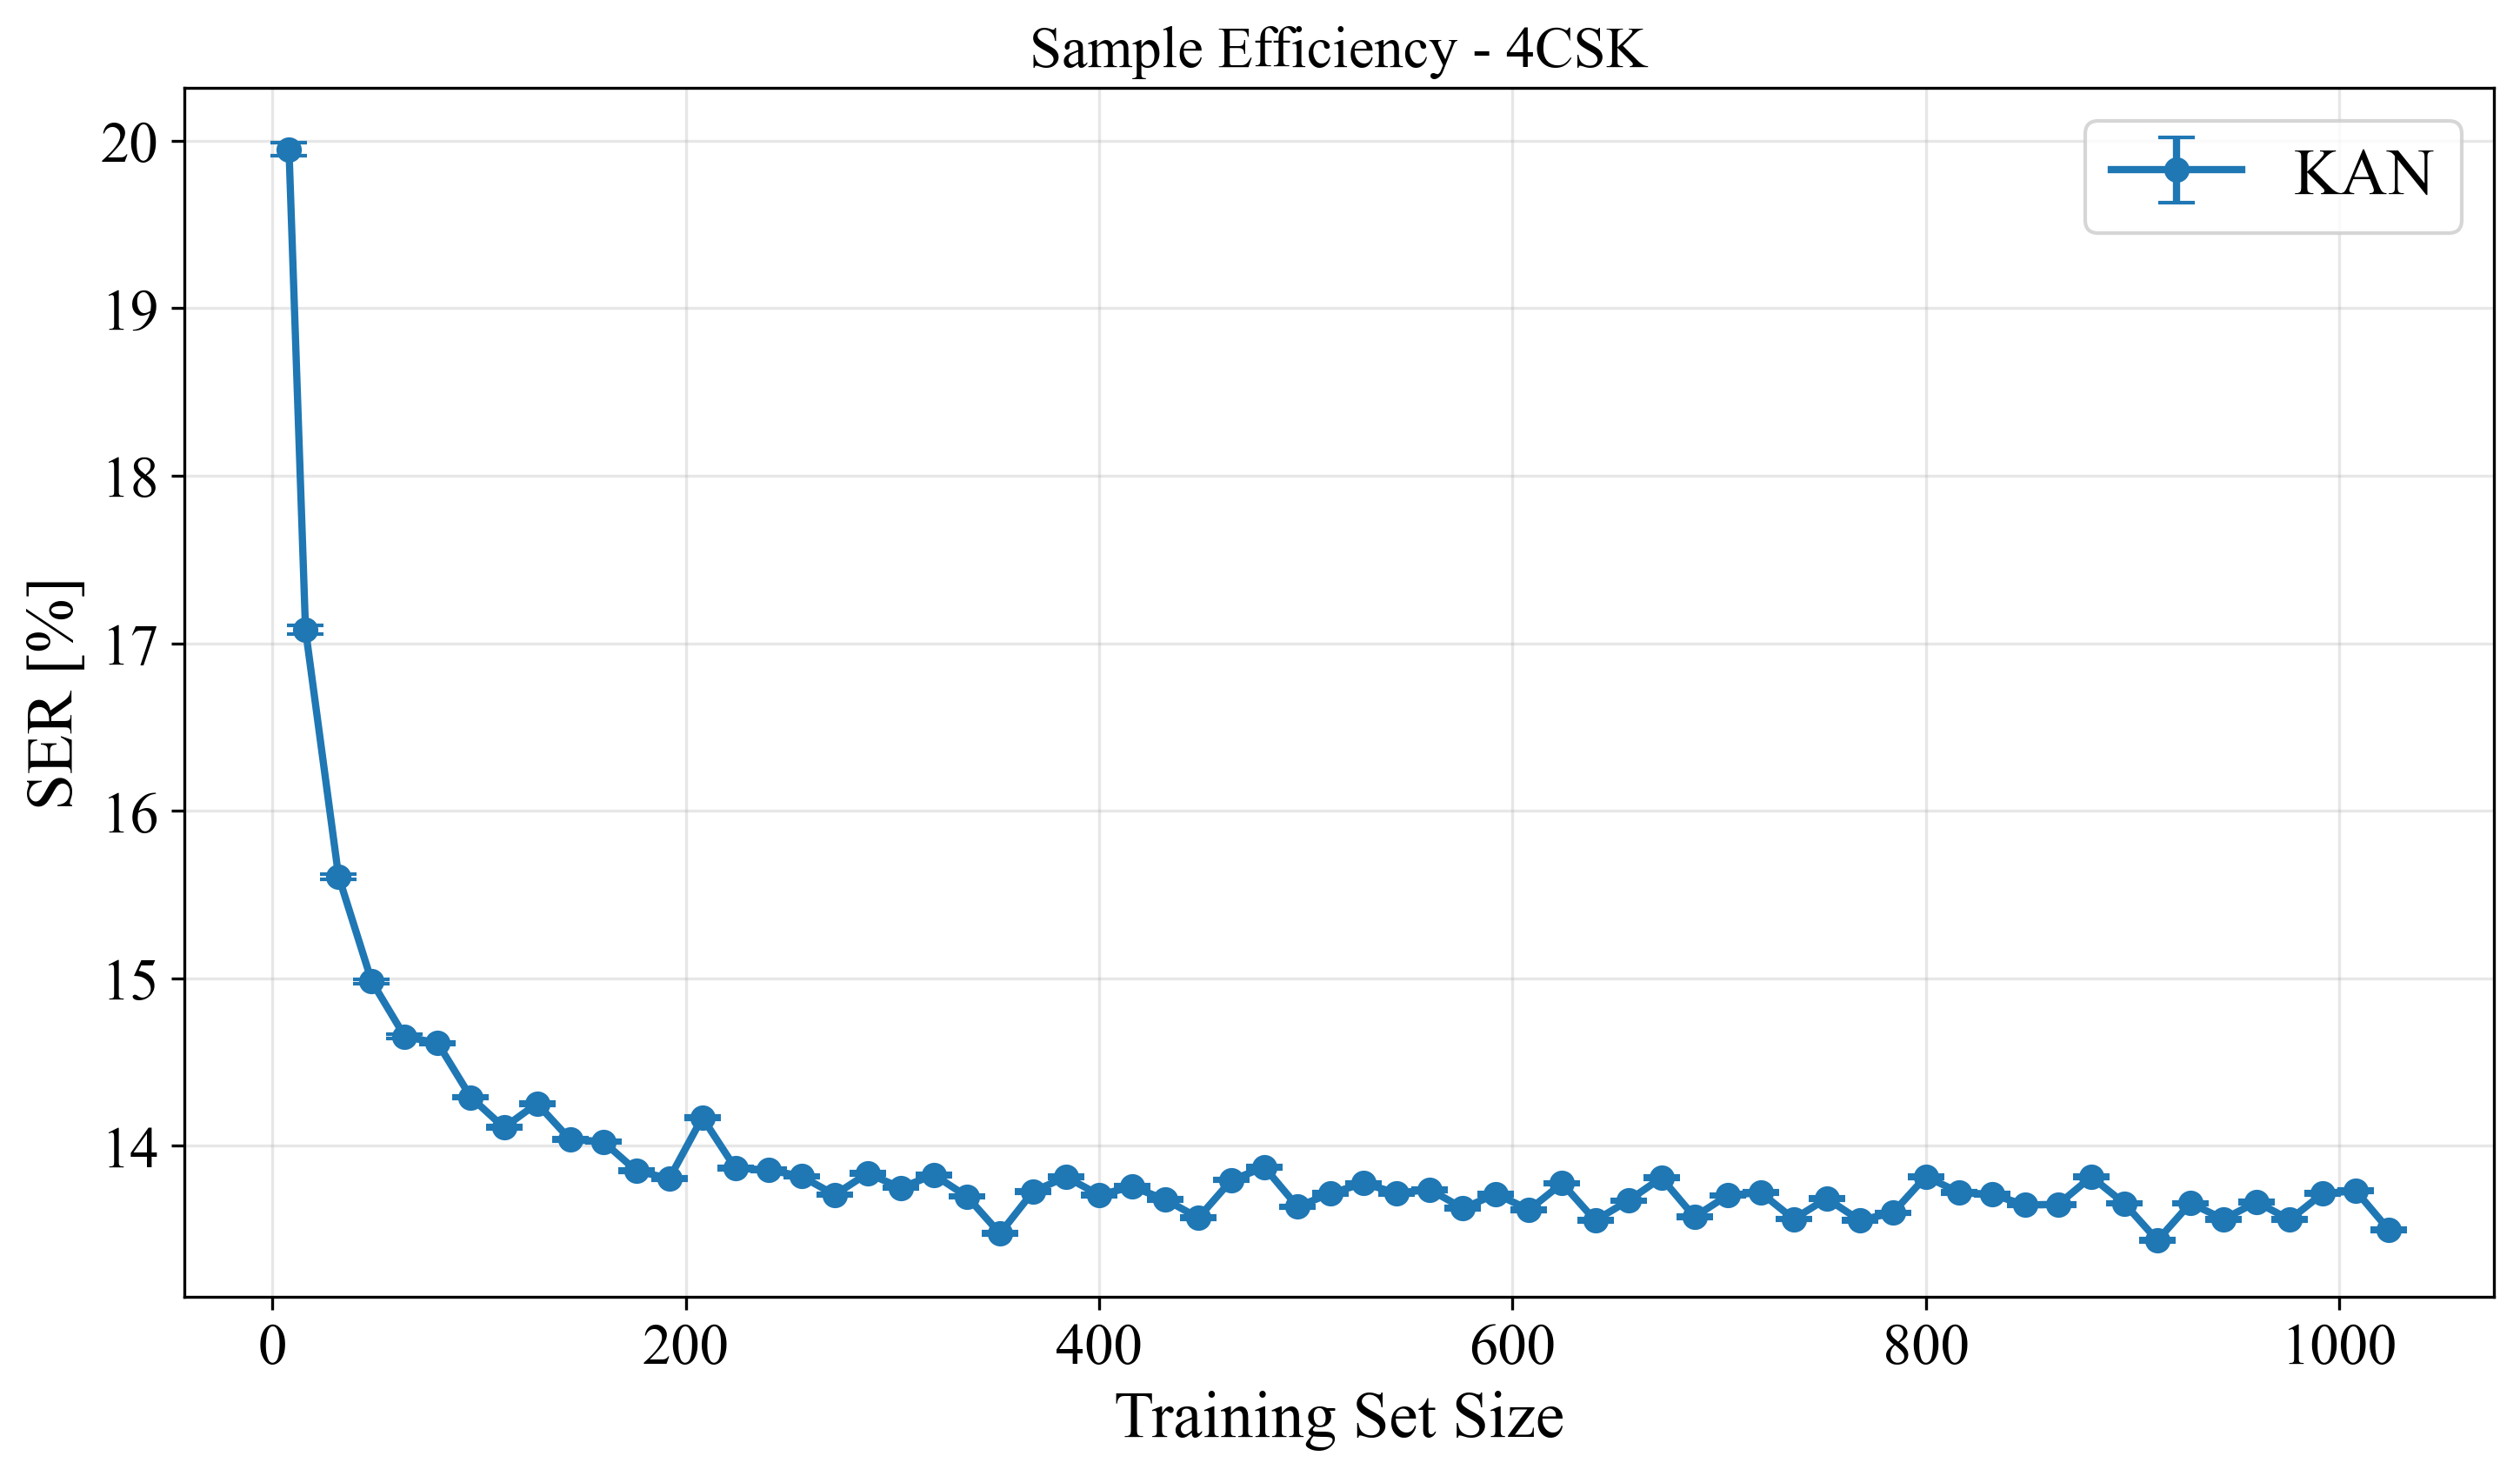

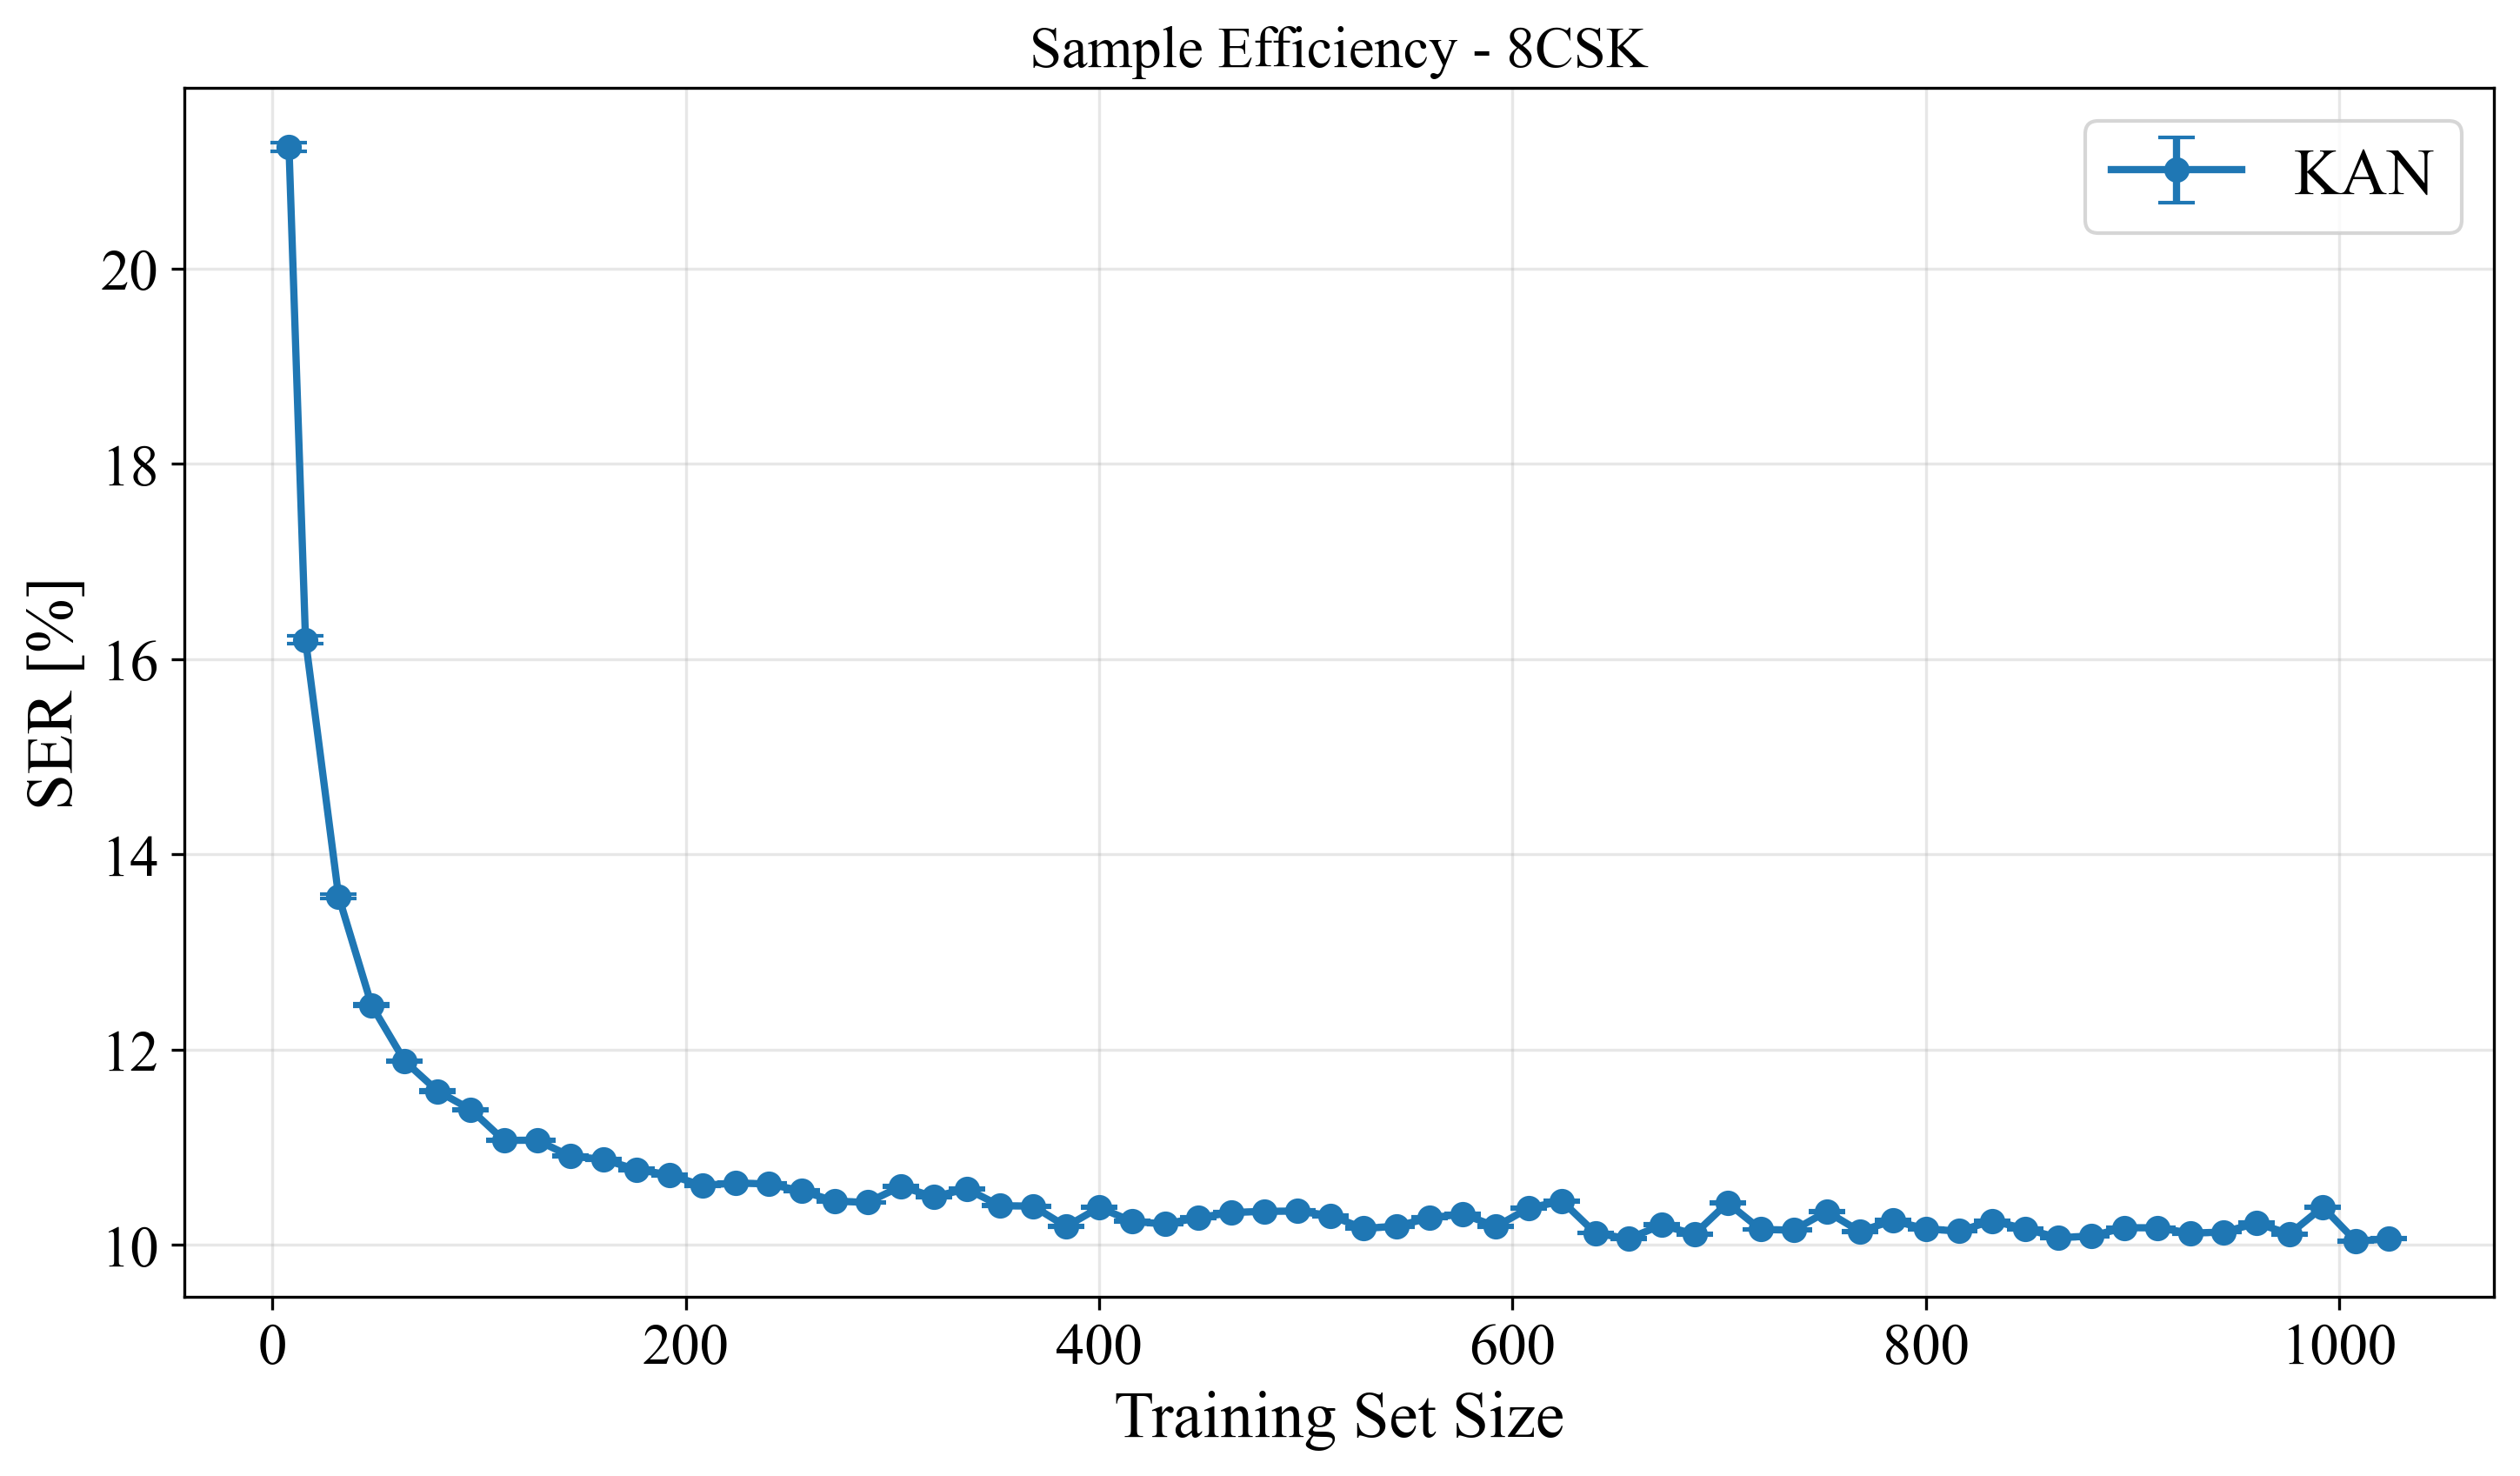

In [16]:
# Plot sample efficiency curves
for dataset in df_efficiency['Dataset'].unique():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model in ['KAN']:
        data = df_efficiency[(df_efficiency['Dataset'] == dataset) & 
                             (df_efficiency['Model'] == model)]
        ax.errorbar(data['Train_Size'], data['Mean_SER']*100, 
                    yerr=data['Std_SER'], label=model, 
                    marker='o', capsize=5, linewidth=2)
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('SER [%]')
    ax.set_title(f'Sample Efficiency - {dataset}')
    # ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    
    filename = f'sample_efficiency_{dataset}'
    plt.savefig(os.path.join(OUTPUT_DIR, filename + '.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(OUTPUT_DIR, filename + '.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

## 4.3 Noise Analysis: FNN vs KAN vs MLE

Compare performance across different noise levels using:
- **FNN-1** (4CSK with voltage features)
- **FNN-3** (8CSK with X_ne, Y_ne, Z_ne)
- **Best KAN** configurations
- **MLE Predictor** (Euclidean distance)

In [ ]:
# Noise analysis experiment
import glob
import pandas as pd
import torch
import numpy as np
import os

# Find all noise level files
noise_files_4csk = sorted([f for f in glob.glob('data_4csk_m*dB.csv') if 'm1000dB' not in f])
noise_files_8csk = sorted([f for f in glob.glob('data_8csk_m*dB.csv') if 'm1000dB' not in f])

noise_results = {
    'Dataset': [], 'Noise_Level_dB': [], 'Model': [], 'Mean_SER': [], 'Std_SER': []
}

# Use local seed base
base_seed = 42

print('Noise Analysis Experiment')
print('='*80)

for dataset_type, noise_files, ref_file, base_file in [
    ('4CSK', noise_files_4csk, 'data_4csk_m1000dB.csv', 'data_4csk.csv'),
    ('8CSK', noise_files_8csk, 'data_8csk_m1000dB.csv', 'data_8csk.csv')
]:
    print(f'\nDataset: {dataset_type}')
    
    # Load reference symbols for MLE (from noiseless data)
    ref_df = pd.read_csv(ref_file)
    reference_symbols = torch.FloatTensor(
        ref_df.groupby('Symbol')[['x', 'y']].mean().values
    ).to(device)
    
    # Get configurations
    if dataset_type == '4CSK':
        fnn_cols = ['Vr', 'Vg', 'Vb']  # FNN-1: voltage features
        kan_cols = best_configs[base_file]['columns']  # Best KAN features
        params = best_configs[base_file]['params']
        fnn_hidden = FNN_CONFIGS[base_file]
    else:  # 8CSK
        fnn_cols = ['X_ne', 'Y_ne', 'Z_ne']  # FNN-3: X_ne, Y_ne, Z_ne
        kan_cols = best_configs[base_file]['columns']  # Best KAN features
        params = best_configs[base_file]['params']
        fnn_hidden = FNN_CONFIGS[base_file]
    
    for noise_file in noise_files:
        # Extract noise level from filename
        noise_level = -int(noise_file.split('_m')[1].replace('dB.csv', ''))
        print(f'  Noise level: {noise_level}dB')
        
        # Test each model with independent runs
        # Removed FNN from the list since it's handled in MATLAB
        for model_type in ['KAN', 'MLE']: # ['FNN', 'KAN', 'MLE']
            sers = []
            
            for run_idx in range(CONFIG['n_repeats']):
                # 1. Generate a unique seed for this independent run
                current_seed = base_seed + run_idx
                
                # 2. Set global seeds for model initialization reproducibility
                np.random.seed(current_seed)
                torch.manual_seed(current_seed)
                
                if model_type == 'MLE':
                    # MLE uses the raw x,y coordinates
                    df = pd.read_csv(noise_file)
                    # Note: If you want MLE to use the same subset as FNN/KAN, 
                    # you would need to use load_data here too. 
                    # Currently, this runs on the FULL dataset.
                    X_test_xy = torch.FloatTensor(df[['x', 'y']].values).to(device)
                    y_test = torch.LongTensor(df['Symbol'].values).to(device)
                    
                    preds = mle_predict(X_test_xy, reference_symbols)
                    ser = (preds != y_test).float().mean().item()
                    
                # elif model_type == 'FNN':
                #     # Load data with unique random_state
                #     X_train, X_test, y_train, y_test, num_classes = load_data(
                #         noise_file, fnn_cols, 
                #         train_size=64, test_size=64,
                #         random_state=current_seed  # <--- Passed here
                #     )
                #     
                #     model = FNN(len(fnn_cols), fnn_hidden, num_classes).to(device)
                #     best_ser, _, _ = train_model(
                #         model, X_train, y_train, X_test, y_test,
                #         epochs=CONFIG['final_epochs'],
                #         lr=1e-3,
                #         optimizer_type='adam'
                #     )
                #     ser = best_ser
                    
                else:  # KAN
                    # Load data with unique random_state
                    X_train, X_test, y_train, y_test, num_classes = load_data(
                        noise_file, kan_cols, 
                        train_size=256, test_size=1024,
                        random_state=current_seed  # <--- Passed here
                    )
                    
                    # Define layers (safe to redefine every loop)
                    layers = [len(kan_cols)] + params['hidden_layers'] + [num_classes]
                    
                    model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
                    best_ser, _, _ = train_model(
                        model, X_train, y_train, X_test, y_test,
                        epochs=CONFIG['final_epochs'],
                        lr=params['lr'],
                        optimizer_type='adam'
                    )
                    ser = best_ser
                
                sers.append(ser)
            
            # Aggregate results
            noise_results['Dataset'].append(dataset_type)
            noise_results['Noise_Level_dB'].append(noise_level)
            noise_results['Model'].append(model_type)
            noise_results['Mean_SER'].append(np.mean(sers))
            noise_results['Std_SER'].append(np.std(sers))

# Reset global seed to base after experiment (optional)
np.random.seed(base_seed)
torch.manual_seed(base_seed)

df_noise = pd.DataFrame(noise_results)
df_noise.to_csv(os.path.join(OUTPUT_DIR, 'noise_analysis_results.csv'), index=False)
print(f'\nResults saved to {OUTPUT_DIR}/noise_analysis_results.csv')

Noise Analysis Experiment

Dataset: 4CSK
  Noise level: -20dB
  Noise level: -22dB
  Noise level: -24dB
  Noise level: -26dB
  Noise level: -28dB
  Noise level: -30dB
  Noise level: -32dB
  Noise level: -34dB
  Noise level: -36dB
  Noise level: -38dB
  Noise level: -40dB
  Noise level: -42dB
  Noise level: -44dB
  Noise level: -46dB
  Noise level: -48dB
  Noise level: -50dB
  Noise level: -52dB
  Noise level: -54dB
  Noise level: -56dB
  Noise level: -58dB
  Noise level: -60dB

Dataset: 8CSK
  Noise level: -20dB
  Noise level: -22dB
  Noise level: -24dB
  Noise level: -26dB
  Noise level: -28dB
  Noise level: -30dB
  Noise level: -32dB
  Noise level: -34dB
  Noise level: -36dB
  Noise level: -38dB
  Noise level: -40dB
  Noise level: -42dB
  Noise level: -44dB
  Noise level: -46dB
  Noise level: -48dB
  Noise level: -50dB
  Noise level: -52dB
  Noise level: -54dB
  Noise level: -56dB
  Noise level: -58dB
  Noise level: -60dB

Results saved to results_refactored/noise_analysis_results.cs

### 4.3.1 Noise Analysis Plots

<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Rafael\AppData\Local\Temp\ipykernel_7896\67951102.py:40: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma^2_n [\\text{dBV}^2]$')


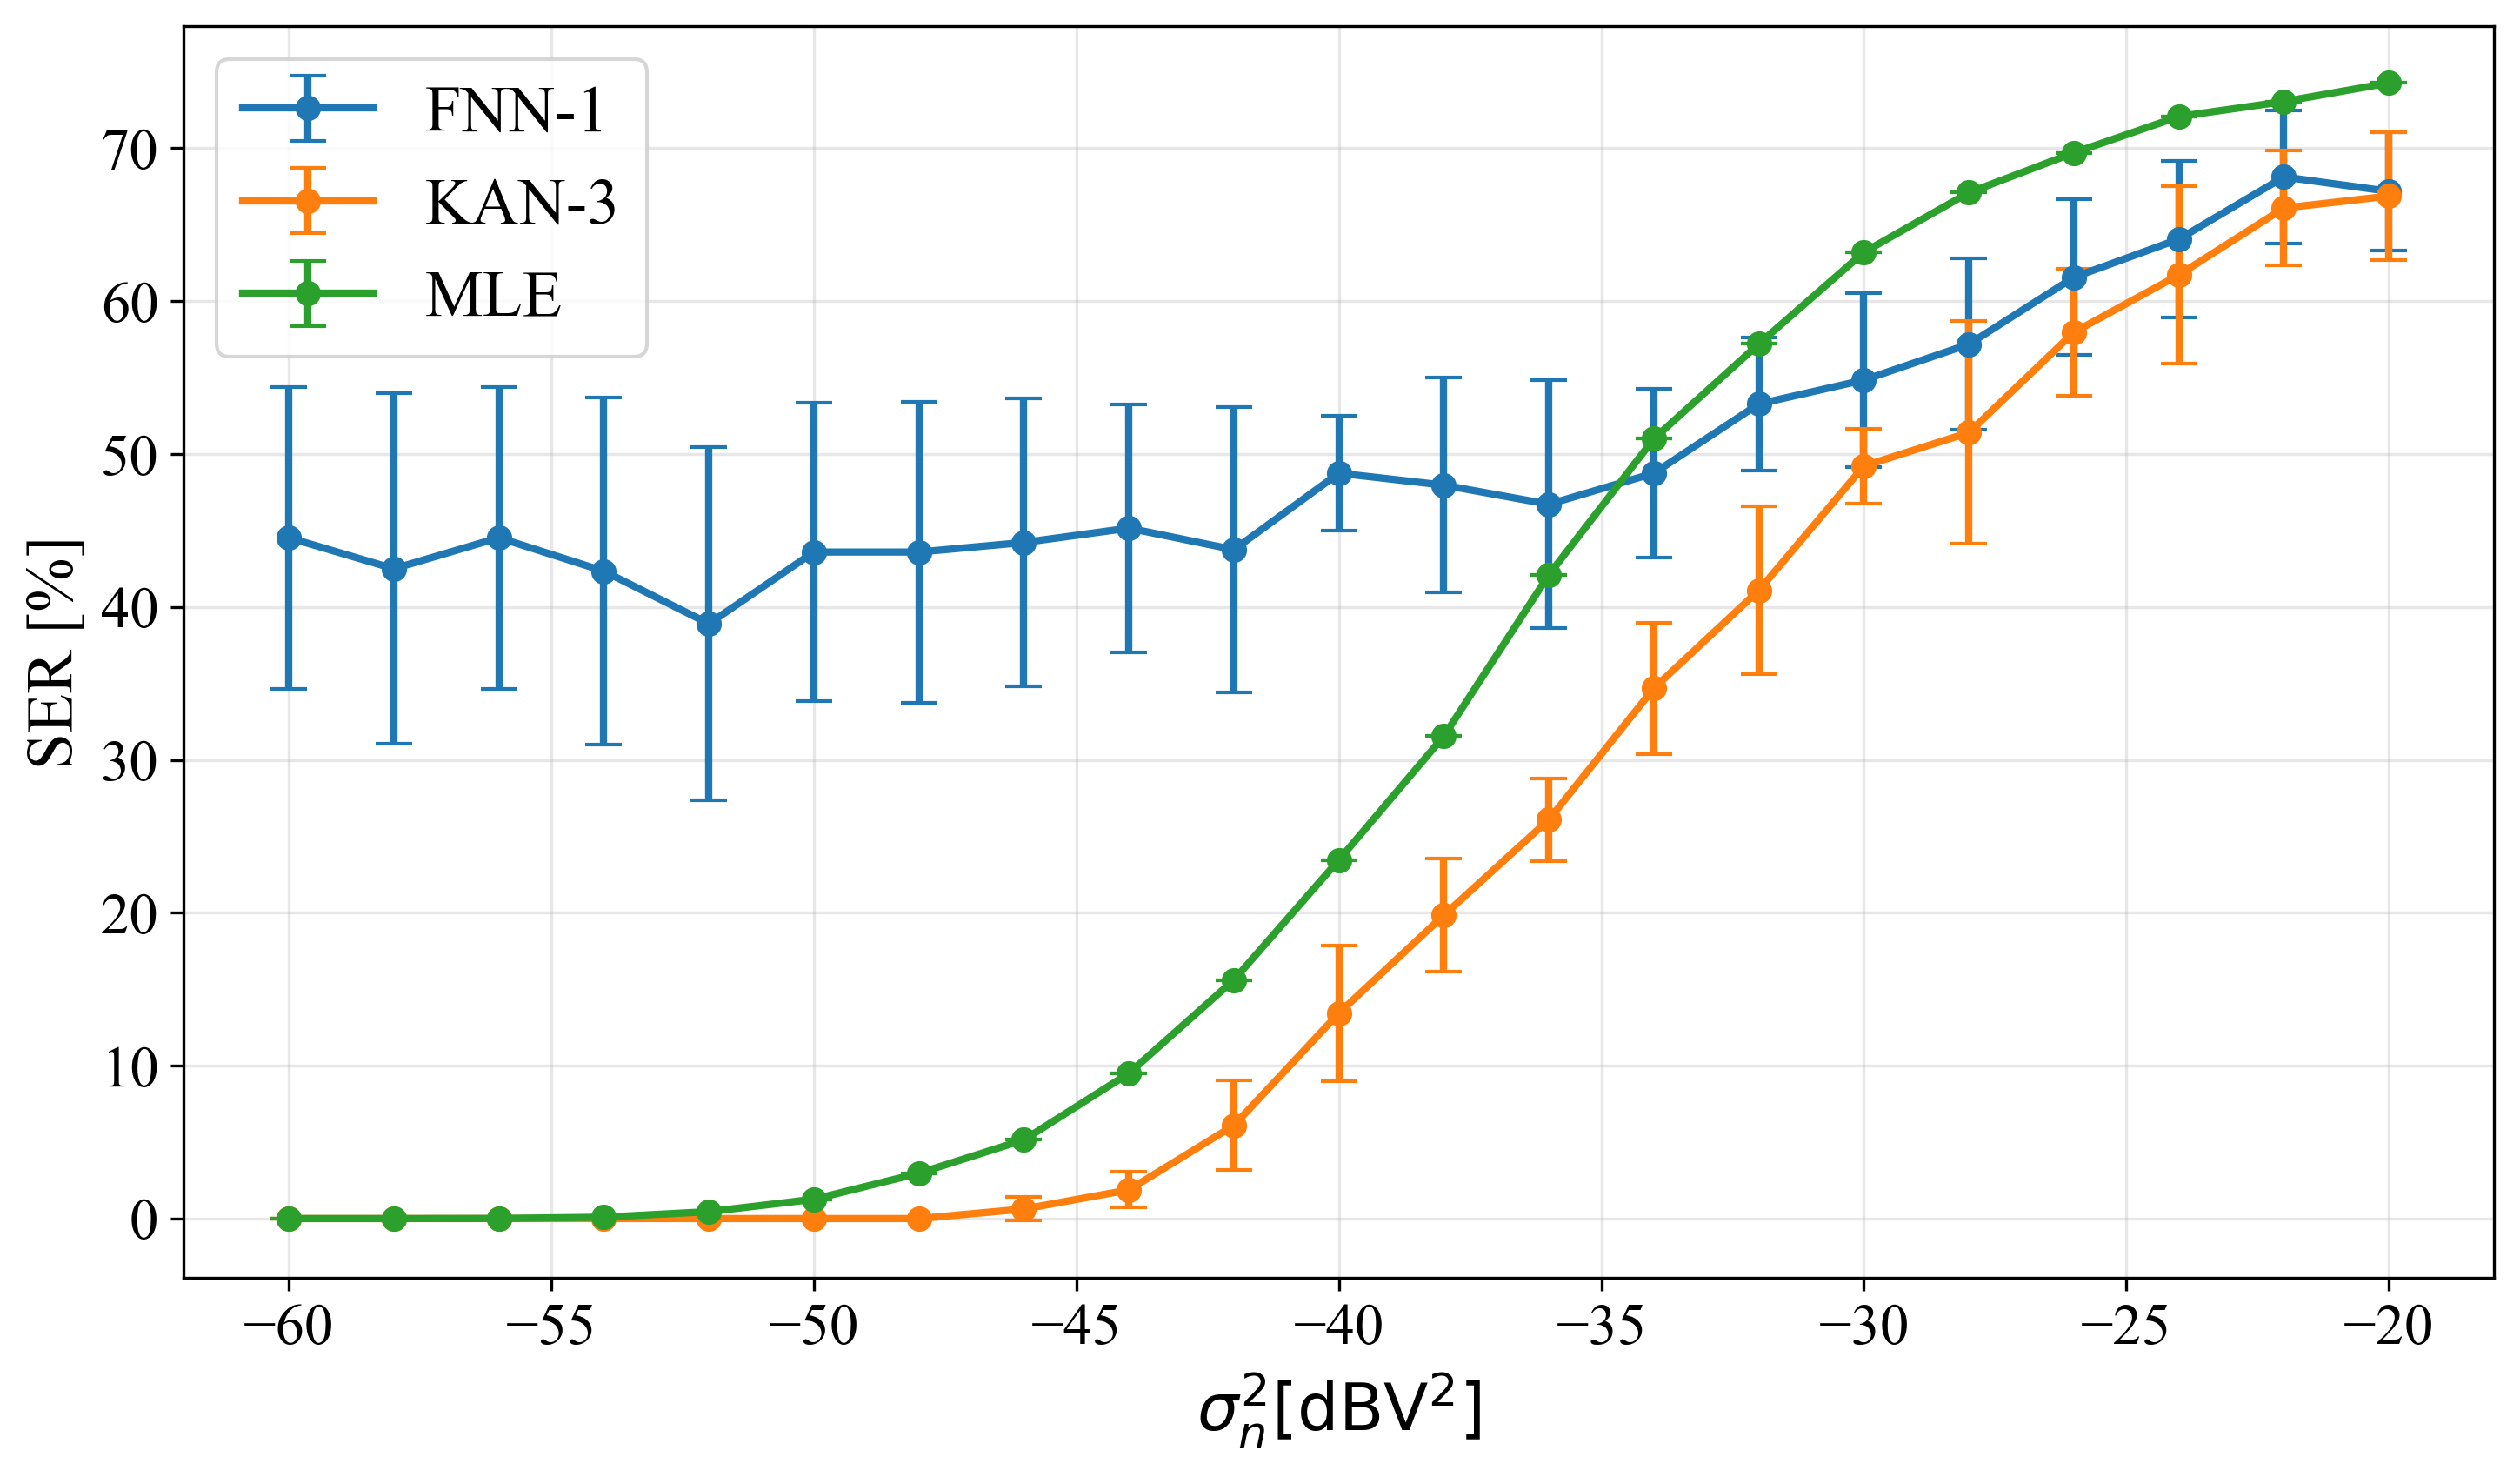

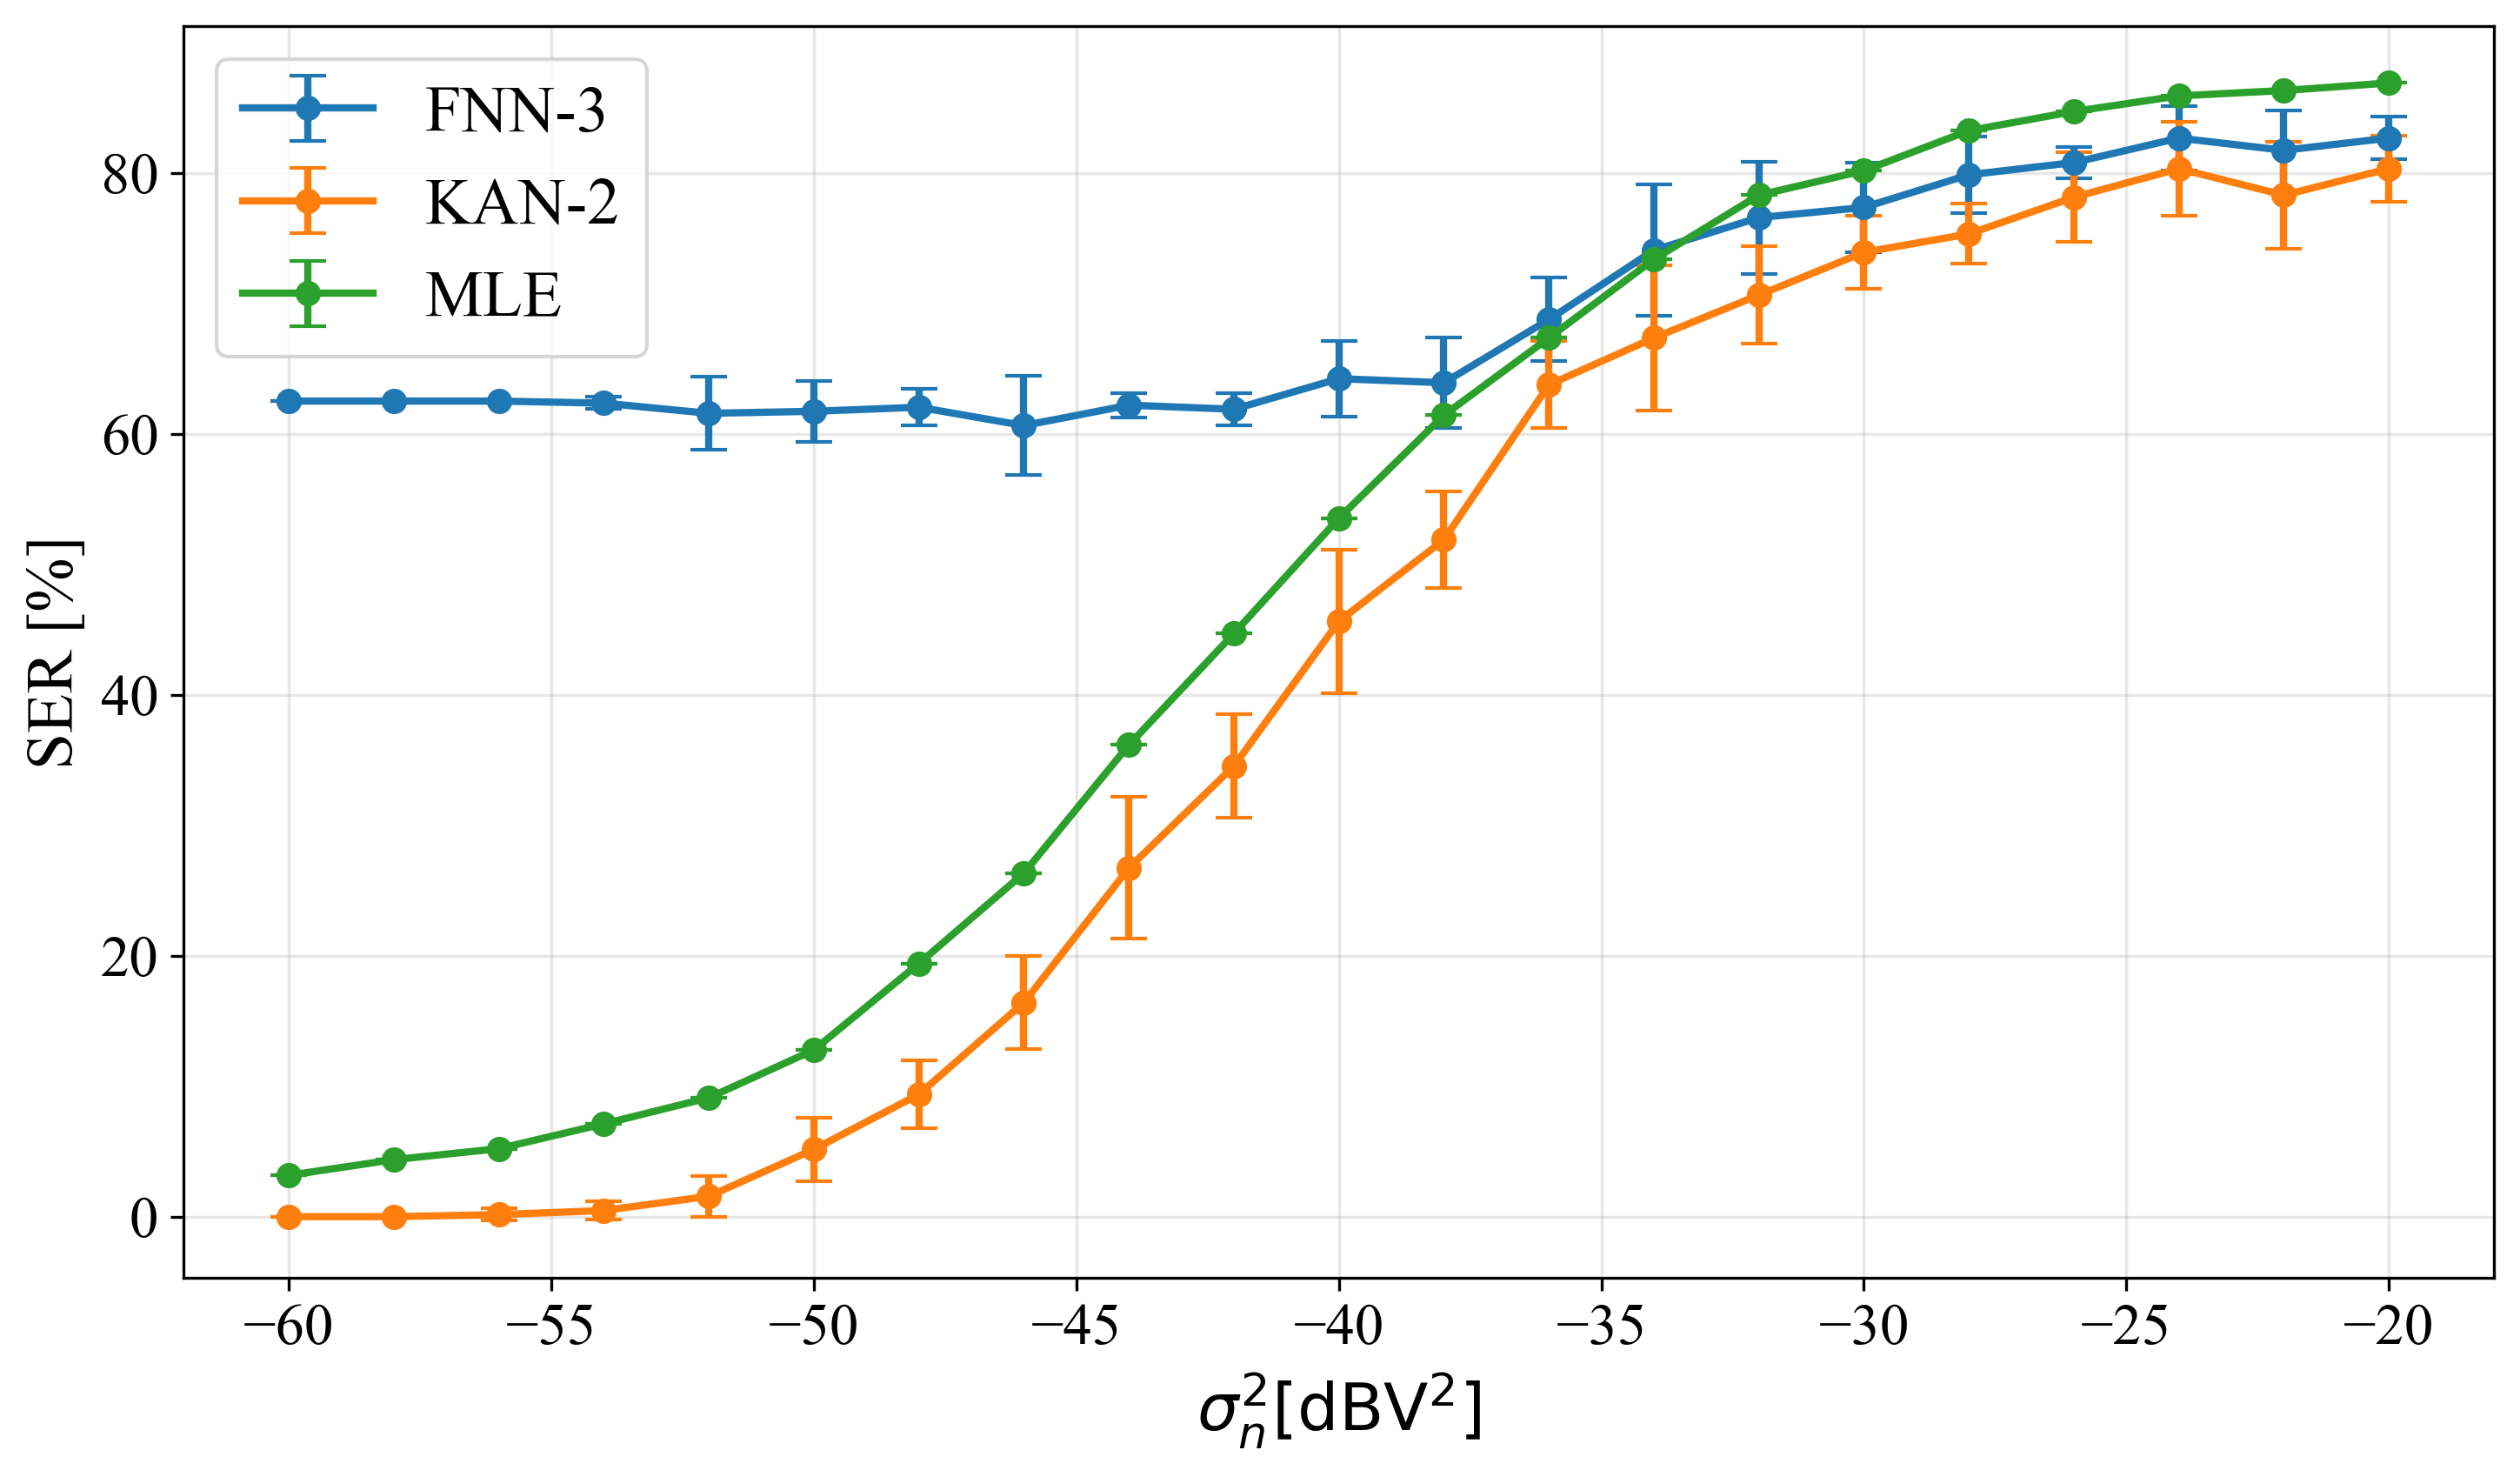

Plots saved to results_refactored


In [50]:
import matplotlib.pyplot as plt
import os

# Plot noise analysis results
for dataset in ['4CSK', '8CSK']:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define custom labels map for this dataset
    if dataset == '4CSK':
        label_map = {
            'FNN': 'FNN-1',
            'KAN': 'KAN-3',
            'MLE': 'MLE'
        }
    else:  # 8CSK
        label_map = {
            'FNN': 'FNN-3',
            'KAN': 'KAN-2',
            'MLE': 'MLE'
        }
    
    for model in ['FNN', 'KAN', 'MLE']:
        data = df_noise[(df_noise['Dataset'] == dataset) & (df_noise['Model'] == model)].copy()
        
        # Sort by noise level (integers 20, 25, etc.)
        data = data.sort_values('Noise_Level_dB')
        
        # Convert file noise level (e.g. 20) to Variance dB (e.g. -20)
        # Assuming 'm20dB' corresponds to a variance of -20 dBV^2
        x_vals = data['Noise_Level_dB']
        
        # Get specific label
        plot_label = label_map.get(model, model)
        
        ax.errorbar(x_vals, data['Mean_SER'] * 100, 
                    yerr=data['Std_SER'] * 100,  # Scale std dev as well
                    label=plot_label, 
                    marker='o', capsize=5, linewidth=2)
    
    ax.set_xlabel('$\sigma^2_n [\\text{dBV}^2]$')
    ax.set_ylabel('SER [%]')
    
    # Title removed as requested
    # ax.set_title(f'Noise Analysis - {dataset}')
    
    ax.legend()
    ax.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    
    filename = f'noise_analysis_{dataset}'
    plt.savefig(os.path.join(OUTPUT_DIR, filename + '.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(OUTPUT_DIR, filename + '.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Good practice to close figure

print(f"Plots saved to {OUTPUT_DIR}")
plt.show()

---
# Section 5: Summary and Conclusions

## 5.1 Best Configurations Summary

In [51]:
print('\BEST CONFIGURATIONS SUMMARY')
print('='*80)

for filename, config in best_configs.items():
    dataset = filename.replace('.csv', '').replace('data_', '').upper()
    print(f'\{dataset}:')
    print(f'  Feature Set: {config["features"]}')
    print(f'  Columns: {config["columns"]}')
    print(f'  Hidden Layers: {config["params"]["hidden_layers"]}')
    print(f'  Mean SER: {config["mean_ser"]:.4f} +/- {config["std_ser"]:.4f}')
    print(f'  Learning Rate: {config["params"]["lr"]}')

print('\n' + '='*80)
print('NOTE: All experiments conducted WITHOUT data normalization')
print('='*80)

\BEST CONFIGURATIONS SUMMARY
\4CSK:
  Feature Set: $T_{wCE}$
  Columns: ['Vr', 'Vg', 'Vb']
  Hidden Layers: [100]
  Mean SER: 0.1078 +/- 0.0226
  Learning Rate: 0.001
\8CSK:
  Feature Set: $T_{wCE}$
  Columns: ['Vr', 'Vg', 'Vb']
  Hidden Layers: [25]
  Mean SER: 0.0906 +/- 0.0195
  Learning Rate: 0.001

NOTE: All experiments conducted WITHOUT data normalization


<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:6: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Rafael\AppData\Local\Temp\ipykernel_7896\1833442322.py:1: SyntaxWarning: invalid escape sequence '\B'
  print('\BEST CONFIGURATIONS SUMMARY')
C:\Users\Rafael\AppData\Local\Temp\ipykernel_7896\1833442322.py:6: SyntaxWarning: invalid escape sequence '\{'
  print(f'\{dataset}:')


## 5.2 Key Findings

1. **Feature Sets**: Analysis shows which feature representations work best
2. **Sample Efficiency**: KAN vs FNN comparison across training set sizes
3. **No Normalization**: All results obtained using raw, unnormalized features
4. **Top Configurations**: Best performing architectures identified for each dataset

All results and visualizations have been saved to the `results_refactored/` directory.